# CHAPTER - 3

# Import the necessary libraries 

# Citation: Foster, David. Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play (2nd Edition), O'Reilly Media, 2023, p. 62.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


# Load the Fashion-MNIST dataset

# Citation: Foster, David. Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play (2nd Edition), O'Reilly Media, 2023, p. 62.

In [2]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255


# Define the encoder

# This section comes from Chapter 3, under the heading "The Encoder", on page 75.

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

# Define the decoder

# This section is found in Chapter 3, under the heading "The Decoder", on page 65.

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

# Reparameterization Trick

# This code is from Chapter 3, under the heading "The Loss Function", on page 80.

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Using the reparameterization trick with the encoder
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


# Building the VAE

# This is from Chapter 3, under the heading "Joining the Encoder to the Decoder", on page 67.

In [6]:
# Instantiate the VAE model
vae_inputs = encoder_inputs
vae_outputs = decoder(z)
vae = keras.Model(vae_inputs, vae_outputs, name="vae")
vae.summary()


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                                

# Compile and Train the VAE

# This step is found in Chapter 3, under the heading "Training the Variational Autoencoder", on page 82.

In [7]:
# Flatten the inputs and outputs explicitly
flattened_inputs = keras.layers.Flatten()(vae_inputs)
flattened_outputs = keras.layers.Flatten()(vae_outputs)

# Define the VAE loss
reconstruction_loss = keras.losses.binary_crossentropy(flattened_inputs, flattened_outputs)
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=keras.optimizers.Adam())

# Train the VAE
vae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))


Epoch 1/30
469/469 [==============================] - 13s 28ms/step - loss: 336.0363 - val_loss: 290.7862
Epoch 2/30
469/469 [==============================] - 13s 28ms/step - loss: 283.7863 - val_loss: 281.2477
Epoch 3/30
469/469 [==============================] - 13s 27ms/step - loss: 278.3144 - val_loss: 277.7227
Epoch 4/30
469/469 [==============================] - 14s 29ms/step - loss: 275.7608 - val_loss: 276.1740
Epoch 5/30
469/469 [==============================] - 14s 29ms/step - loss: 273.8802 - val_loss: 274.3053
Epoch 6/30
469/469 [==============================] - 14s 29ms/step - loss: 272.7556 - val_loss: 275.4696
Epoch 7/30
469/469 [==============================] - 15s 31ms/step - loss: 271.7546 - val_loss: 273.3010
Epoch 8/30
469/469 [==============================] - 13s 28ms/step - loss: 270.8649 - val_loss: 272.2119
Epoch 9/30
469/469 [==============================] - 14s 29ms/step - loss: 270.1784 - val_loss: 271.7601
Epoch 10/30
469/469 [=========================

# Visualizing the Latent Space

# This step is from Chapter 3, under the heading "Exploring the Latent Space", on page 87.

79/79 [==============================] - 0s 2ms/step


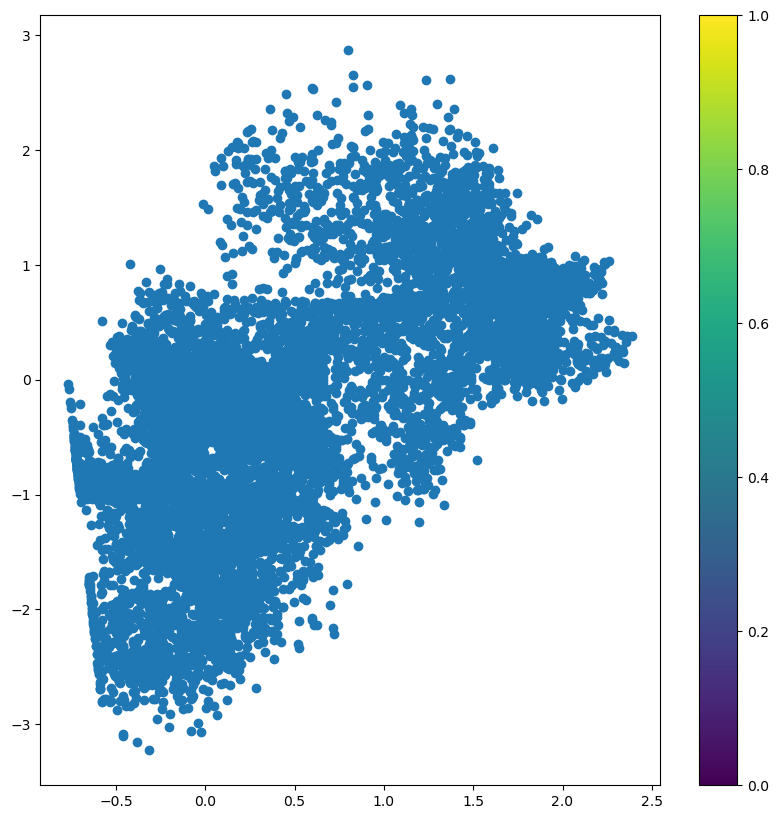

In [10]:
# Display a 2D plot of digit classes in the latent space
import matplotlib.pyplot as plt

def plot_latent_space(encoder, x_test, batch_size=128):
    z_mean, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(10, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.show()

plot_latent_space(encoder, x_test)


# Generating New Images from the Latent Space

# Citation: Foster, David. Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play (2nd Edition), O'Reilly Media, 2023, p. 88.

1/1 [==============================] - 0s 5ms/step


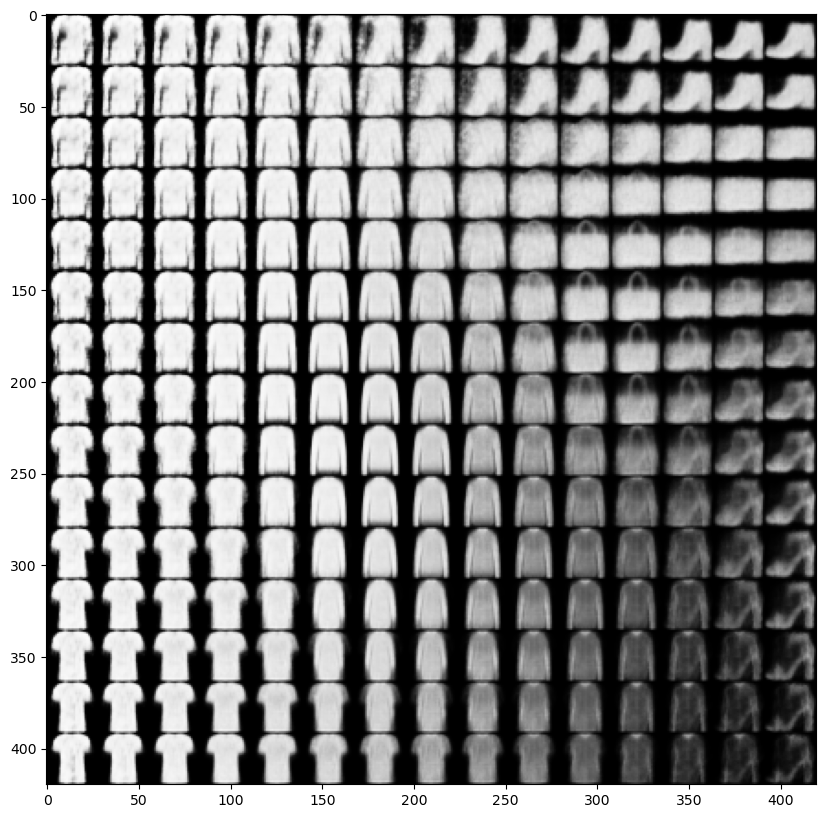

In [11]:
def generate_images(decoder, n=15, scale=1.0):
    # Create a grid of values for sampling from the latent space
    figure = np.zeros((28 * n, 28 * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(28, 28)
            figure[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

# Generate and visualize new images
generate_images(decoder)


# Saving and Loading the VAE Model

# We’ll save both the encoder and decoder models, so WE can load them later without retraining.

In [17]:
# Save the models 
encoder.save('vae_encoder.keras')
decoder.save('vae_decoder.keras')

if True:
    print("Saved!")

Saved!


In [18]:
# Load the encoder and decoder models
loaded_encoder = keras.models.load_model('vae_encoder.keras')
loaded_decoder = keras.models.load_model('vae_decoder.keras')

if True:
    print("Loaded!")

Loaded!


# Additional potential techniques that are presented from the page 85 ro 94

# Interpolating in the Latent Space

1/1 [==============================] - 0s 6ms/step


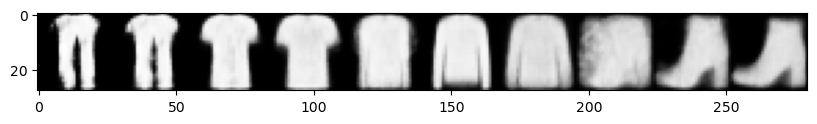

In [19]:
def interpolate_images(decoder, start, end, steps=10):
    z_start = np.array([start])
    z_end = np.array([end])
    z_steps = np.linspace(z_start, z_end, steps)
    
    figure = np.zeros((28, 28 * steps))
    for i, z in enumerate(z_steps):
        x_decoded = decoder.predict(z)
        digit = x_decoded[0].reshape(28, 28)
        figure[:, i * 28:(i + 1) * 28] = digit

    plt.figure(figsize=(10, 1))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

# Interpolate between two random points
start_point = np.random.normal(size=(2,))
end_point = np.random.normal(size=(2,))
interpolate_images(loaded_decoder, start_point, end_point)


# Visualizing Loss Curves

Epoch 1/30
469/469 [==============================] - 13s 28ms/step - loss: 263.6646 - val_loss: 266.9012
Epoch 2/30
469/469 [==============================] - 13s 28ms/step - loss: 263.4449 - val_loss: 266.8419
Epoch 3/30
469/469 [==============================] - 13s 28ms/step - loss: 263.3791 - val_loss: 265.8852
Epoch 4/30
469/469 [==============================] - 13s 28ms/step - loss: 263.0624 - val_loss: 265.4944
Epoch 5/30
469/469 [==============================] - 13s 28ms/step - loss: 263.0081 - val_loss: 266.1175
Epoch 6/30
469/469 [==============================] - 13s 28ms/step - loss: 262.8722 - val_loss: 265.5484
Epoch 7/30
469/469 [==============================] - 14s 29ms/step - loss: 262.6908 - val_loss: 265.5237
Epoch 8/30
469/469 [==============================] - 14s 29ms/step - loss: 262.5895 - val_loss: 265.6228
Epoch 9/30
469/469 [==============================] - 13s 28ms/step - loss: 262.5063 - val_loss: 265.0278
Epoch 10/30
469/469 [=========================

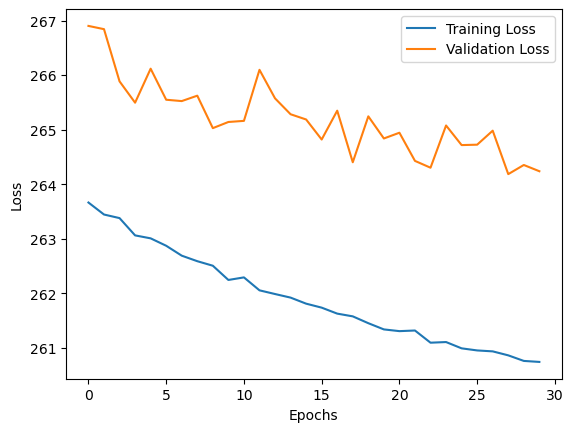

In [20]:
history = vae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Latent Space Arithmetic

# Explanation:
Sampling Latent Vectors: We sample two random vectors from the latent space.

Generating Images: We generate images corresponding to these vectors using the decoder.

Arithmetic Operation: We perform an addition (or subtraction) of the two latent vectors.

Generating New Image: The resulting vector is fed into the decoder to generate a new image.

Visualization: We display the original images and the result side by side.

1/1 [==============================] - 0s 6ms/step


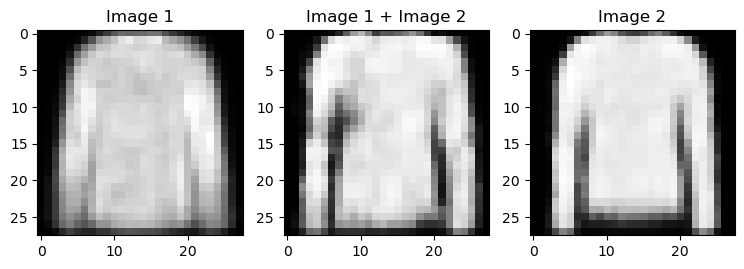

In [21]:
# Function to perform latent space arithmetic
def latent_space_arithmetic(decoder, vector1, vector2, operation='addition'):
    if operation == 'addition':
        z_new = vector1 + vector2
    elif operation == 'subtraction':
        z_new = vector1 - vector2
    else:
        raise ValueError("Operation must be 'addition' or 'subtraction'")

    generated_image = decoder.predict(z_new)
    return generated_image

# Sample random latent vectors
z_sample1 = np.random.normal(size=(1, latent_dim))
z_sample2 = np.random.normal(size=(1, latent_dim))

# Generate images from the sampled vectors
img1 = decoder.predict(z_sample1)
img2 = decoder.predict(z_sample2)

# Perform addition in latent space
img_added = latent_space_arithmetic(decoder, z_sample1, z_sample2, 'addition')

# Display the results
plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.imshow(img1[0].reshape(28, 28), cmap='gray')
plt.title('Image 1')

plt.subplot(1, 3, 2)
plt.imshow(img_added[0].reshape(28, 28), cmap='gray')
plt.title('Image 1 + Image 2')

plt.subplot(1, 3, 3)
plt.imshow(img2[0].reshape(28, 28), cmap='gray')
plt.title('Image 2')

plt.show()


# Sampling from a Grid in the Latent Space

# Explanation:
Grid Coordinates: Here We creatd a grid of pointss in the latent space by linearly spacing values between -scale and scale.

Decoding: Each point in the grid is decoded into an image.

Visualization: Images are arranged in a grid format to show transitions between different latent space regions.

1/1 [==============================] - 0s 7ms/step


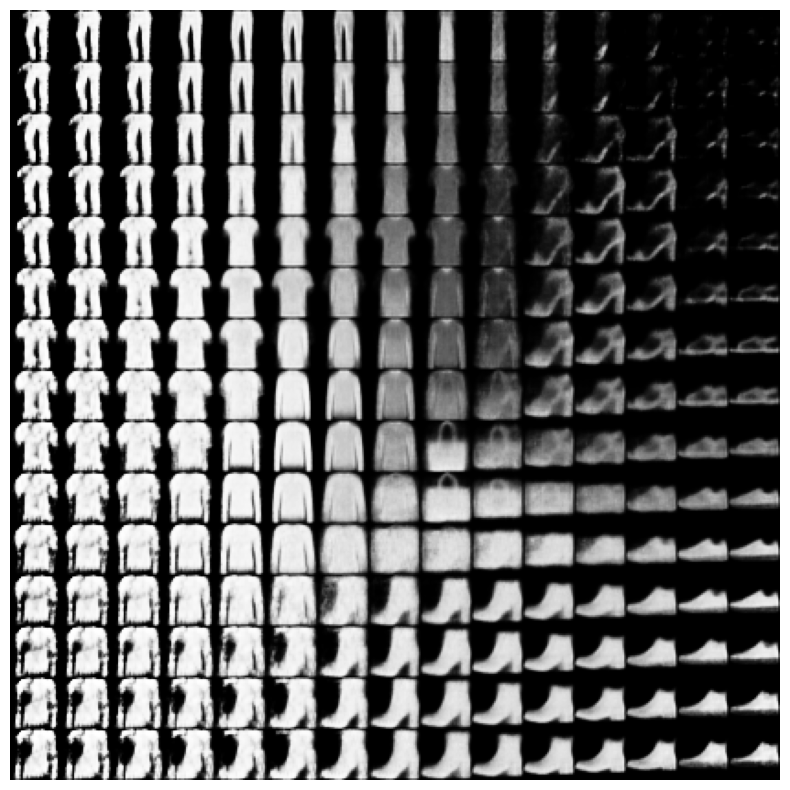

In [22]:
def plot_latent_space_grid(decoder, n=15, scale=2.0):
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # Linearly spaced coordinates corresponding to the 2D plot
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

# Plot the grid of images
plot_latent_space_grid(decoder)


# Visualizing the Latent Space with Labels

# Explanation:
Loading Data with Labels: We reload the test set to include labels.
    
Latent Representations: We obtain the z_mean for the test data.

Visualization: We create a scatter plot of the latent dimensions, color-coded by the class labels.

Interpretation: This helps to see how well the VAE separates different classes in the latent space.

313/313 [==============================] - 0s 710us/step


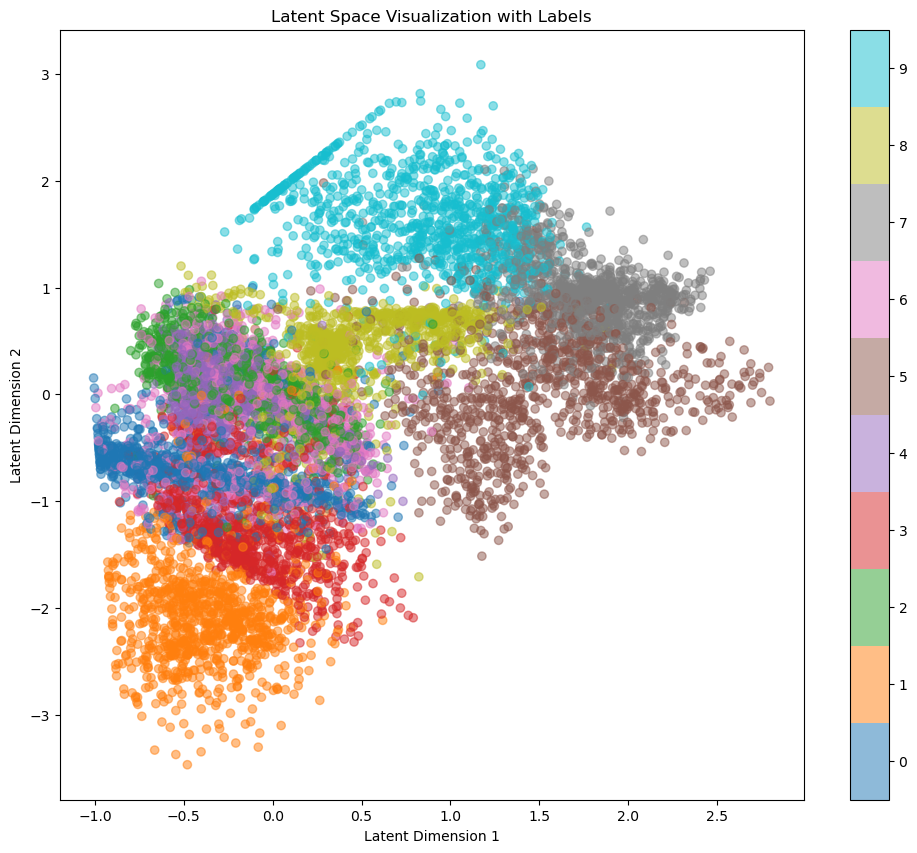

In [23]:
# Reload the dataset with labels
(x_train_full, y_train_full), (x_test_full, y_test_full) = keras.datasets.fashion_mnist.load_data()
x_test_full = np.expand_dims(x_test_full, -1).astype("float32") / 255

# Get the latent representations
z_mean_test, _ = encoder.predict(x_test_full)

# Plotting
plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_mean_test[:, 0], z_mean_test[:, 1], c=y_test_full, cmap='tab10', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.clim(-0.5, 9.5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization with Labels')
plt.show()


# Evaluating Reconstruction Quality

# Explanation:
Selection: We select a few images from the test set.
    
Reconstruction: We pass them through the VAE to get reconstructed images.

Visualization: Original and reconstructed images are displayed for comparison.
                                                              
Insight: This helps evaluate how well the VAE preserves important features.

1/1 [==============================] - 0s 81ms/step


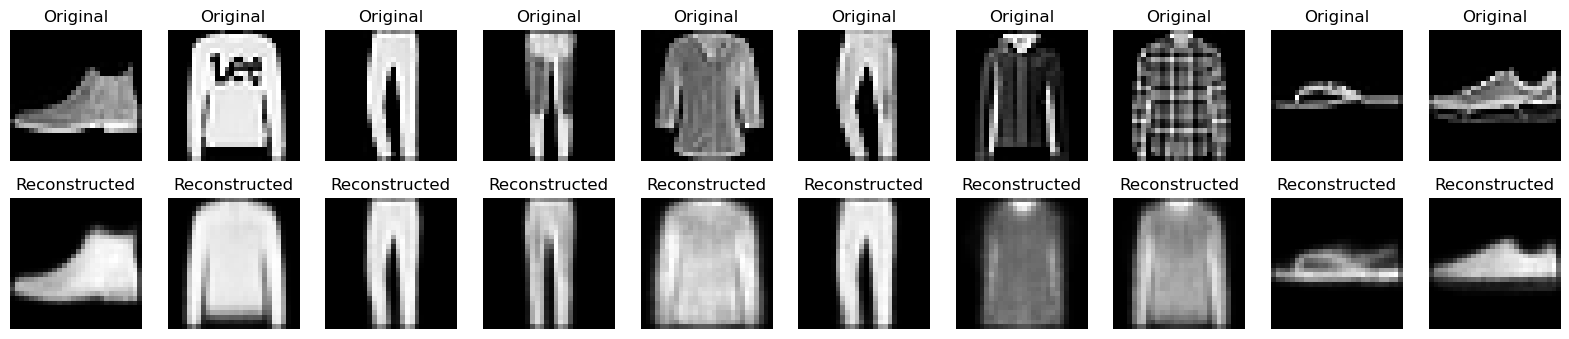

In [24]:
# Select a subset of test images
num_images = 10
test_images = x_test[:num_images]

# Get the reconstructed images
reconstructed_images = vae.predict(test_images)

# Plot original and reconstructed images
plt.figure(figsize=(20, 4))
for i in range(num_images):
    # Original images
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()


# Analyzing Individual Latent Dimensions

# Explanation:
Fixed Latent Vector: Start with a zero vector in the latent space.

Manipulation: Systematically vary one dimension while keeping others constant.
    
Visualization: Observe how changes in that dimension affect the output image.

Interpretation: This can reveal whether certain dimensions capture specific features like rotation, thickness, etc.


1/1 [==============================] - 0s 6ms/step


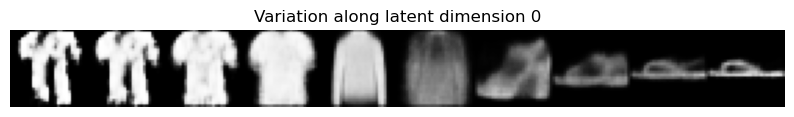

In [25]:
def manipulate_latent_dimension(decoder, dim_index, range_values=(-3, 3), steps=10):
    z = np.zeros((1, latent_dim))
    digit_size = 28
    figure = np.zeros((digit_size, digit_size * steps))

    values = np.linspace(range_values[0], range_values[1], steps)
    for i, val in enumerate(values):
        z_new = np.array(z)
        z_new[0, dim_index] = val
        x_decoded = decoder.predict(z_new)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[:, i * digit_size: (i + 1) * digit_size] = digit

    plt.figure(figsize=(10, 2))
    plt.imshow(figure, cmap='Greys_r')
    plt.axis('Off')
    plt.title(f'Variation along latent dimension {dim_index}')
    plt.show()

# Analyze the first latent dimension
manipulate_latent_dimension(decoder, dim_index=0)


# Using the VAE for Data Augmentation

# Explanation:
Sampling: Generate a number of new latent vectors.

Decoding: Convert them into images using the decoder.

Usage: The synthetic images can be added to your dataset to improve the performance of other models.

32/32 [==============================] - 0s 4ms/step


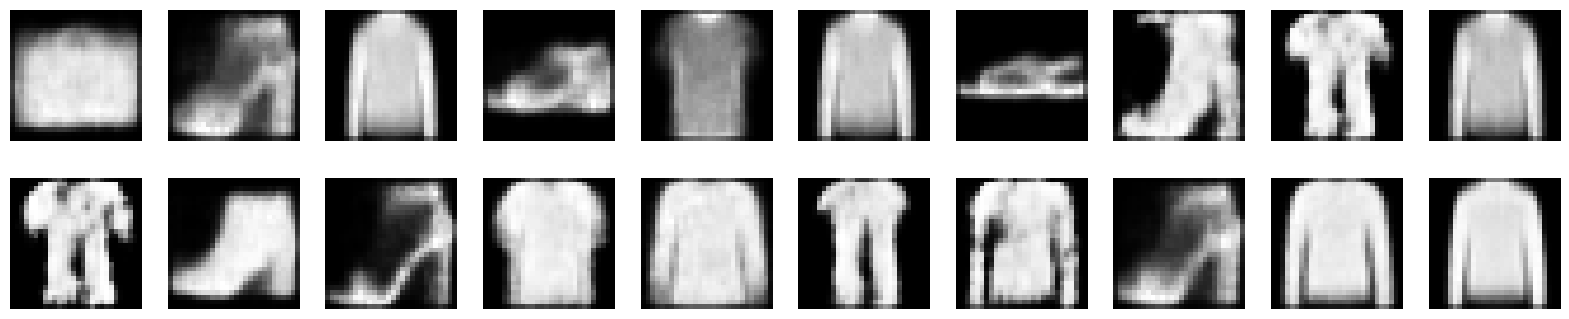

In [26]:
# Generate synthetic images
num_new_images = 1000
z_new_samples = np.random.normal(size=(num_new_images, latent_dim))
generated_images = decoder.predict(z_new_samples)

# Visualize some of the generated images
plt.figure(figsize=(20, 4))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

# You can combine generated_images with your original dataset for training


# This is the summary of what I have learnt from the Chapter 3 Variational Autoencoders

Variational Autoencoders are a class of generative models that learn the underlying distribution of data in order to generate new points by sampling from a latent space. The following summary will cover most of the main concepts and techniques covered throughout Chapter 3 in Generative Deep Learning:

1. Introduction to Autoencoders and VAEs
Autoencoders are neural networks trained in such a way that they learn to represent the data in an efficient manner, in an unsupervised way. They consist of two parts: an encoder, used for compressing the input; a decoder, which reconstructs the input from the representation by using a compressed one.

VAE adds a probabilistic dimension to the basic autoencoder architecture: essentially, at the time of learning fixed encoding for each input, VAE learns over a distribution in latent space that enables flexibility and generalization in generating new data points.

3. Architecture of VAE
 - Encoder: It encodes the input images into a latent space. Representation is in terms of two variables-the mean (`z_mean`) and log variance (`z_log_var`)-that describe the distribution in the latent space.

 - Reparameterization Trick: A critical feature of VAEs in order to allow the backpropagation through the stochastic part of the model. In other words, it allows the model to make a differentiable sampling from the latent space by expressing the latent variables as a deterministic function of mean, variance and noise.

 - Decoder: It takes samples from the latent space and reconstructs the data in the input. This is similar to the usual autoencoder.

3. VAE Loss Function
- The VAE loss function comprises mainly two parts:
- Reconstruction Loss: It calculates the similarity of the decoded data to the original input. Commonly, this is measured by binary cross-entropy when working with image data.
- KL divergence: Penalizes the learned latent space for having a normal distribution. The KL divergence is computed between the learned distribution and the standard Gaussian distribution. The minimum this loss provides the latent space desirable properties to sample from the latent space.

Our implementation of the above loss function considered both reconstruction error and divergence from Gaussian distribution.

4. Training the VAE
We trained the VAE on the Fashion-MNIST dataset, which comprises grayscale images of fashion items such as shirts, trousers, shoes, etc.
With the encoder and decoder defined along with the loss, we compiled and fitted the VAE for 30 epochs, observing the loss decrease progressively over time.

Playing with the Latent Space
We then visualized the latent space post-training as a way to understand how the model arranges data points. The 2-D latent space could be conceptualized as a compressed version of the input space in which similar data points clumped together.
That gave us an intuition for what the underlying structure of the dataset is, and how different data points are encoded by the VAE.

6. Generating New Data
We utilized the decoder in order to create new images simply by sampling from the latent space. This was indicative of the generative capability of VAE since, by interpolating between points of the latent space, we could obtain totally new fashion images.
Smooth transitions between generated images showed that VAE learned continuous representations of data.

 

7. Saving and Loading Models
We finally saved both the encoder and decoder models in `.keras` format to enable their future reuse without retraining of the model; hence, to make the VAE practical for putting into services or further experimentation.

My Key Takeaways:
Variational Autoencoders are one of the powerful generative models that learn the continuous latent space and generate new realistic data by doing sampling in that space.

• This reparameterization trick enables back-propagation of gradients through the stochastic sampling process; hence, VAEs are differentiable and hence trainable.

• Reconstruction loss and KL divergence together give an incentive for the VAE not only to reconstruct input data but also to learn meaningful, Gaussian latent space.

• VAEs can serve image generation, data augmentation, and unsupervised feature learning among many others.

